In [171]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import warnings 

warnings.filterwarnings('ignore')

# Environment

Börja med att skapa en ny environment, kalla den ex. **deeplearning** 

I din nya environment, installera alla vanliga paket (ipython, ipykernel, pandas, numpy, matplotlib, seaborn osv)

Därefter, gå in på https://pytorch.org/get-started/locally/ och följ instruktioner för att installera PyTorch.

Snabbkommandon:

        GPU-support 
            pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126

        CPU only: 
            pip3 install torch torchvision

In [172]:
import torch
torch.cuda.is_available()

False

# Load and transform data

**1) ladda**

Vi kommer att använda följande dataset:

https://archive.ics.uci.edu/dataset/320/student+performance

Vårt mål kommer vara att förutspå varje elevs slutbetyg, beroende på olika faktorer.
I hemsidan kan du läsa på mer detaljerat om vad varje kolumn beskriver!

In [173]:
students_df = pd.read_csv('student-por.csv', delimiter=';')

**2) Initial data check**

Vi vill predikta 'G3' (slutbetyg) givet övriga attribut.

Slutbetyget anges med ett värde på 0-20, där 20 är bästa betyg.

In [174]:
students_df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,10,11,10
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,15,15,16
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,11,12,9
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,10,10,10


G3
11    104
10     97
13     82
12     72
14     63
15     49
16     36
9      35
8      35
17     29
18     15
0      15
7      10
6       3
19      2
1       1
5       1
Name: count, dtype: int64


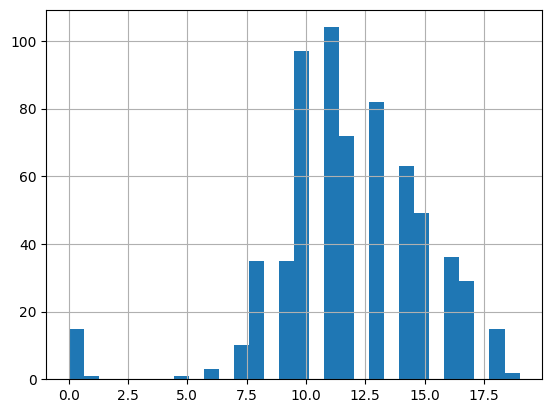

In [175]:
print(students_df.G3.value_counts())

students_df.G3.hist(bins=30);

Som syns ovan ser vi att ingen fått maxbetyg (20) men att två elever uppnåde 19 iaf. De allra flesta verkar fått slutbetyg mellan 9 till 15.

**3) välj bort vissa kolumner**

In [176]:
#vi väljer bort ett par kolumner för enkelhetens skull, och tar endast med ett par utvalda

target_column = ['G3']
feature_columns = ['school', 'sex', 'age', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'reason',
                   'studytime', 'failures', 'higher', 'internet', 'Dalc', 'Walc', 'health']

students_df = students_df[feature_columns + target_column]

students_df

,school,sex,age,famsize,Pstatus,Medu,Fedu,reason,studytime,failures,higher,internet,Dalc,Walc,health,G3
0,GP,F,18,GT3,A,4,4,course,2,0,yes,no,1,1,3,11
1,GP,F,17,GT3,T,1,1,course,2,0,yes,yes,1,1,3,11
2,GP,F,15,LE3,T,1,1,other,2,0,yes,yes,2,3,3,12
3,GP,F,15,GT3,T,4,2,home,3,0,yes,yes,1,1,5,14
4,GP,F,16,GT3,T,3,3,home,2,0,yes,no,1,2,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,GT3,T,2,3,course,3,1,yes,yes,1,2,5,10
645,MS,F,18,LE3,T,3,1,course,2,0,yes,yes,1,1,1,16
646,MS,F,18,GT3,T,1,1,course,2,0,yes,no,1,1,5,9
647,MS,M,17,LE3,T,3,1,course,1,0,yes,yes,3,4,2,10


**4) transformera data**

In [177]:
students_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   school     649 non-null    object
 1   sex        649 non-null    object
 2   age        649 non-null    int64 
 3   famsize    649 non-null    object
 4   Pstatus    649 non-null    object
 5   Medu       649 non-null    int64 
 6   Fedu       649 non-null    int64 
 7   reason     649 non-null    object
 8   studytime  649 non-null    int64 
 9   failures   649 non-null    int64 
 10  higher     649 non-null    object
 11  internet   649 non-null    object
 12  Dalc       649 non-null    int64 
 13  Walc       649 non-null    int64 
 14  health     649 non-null    int64 
 15  G3         649 non-null    int64 
dtypes: int64(9), object(7)
memory usage: 81.3+ KB


Alla inputs och outputs för neurala nätverk måste först siffror (integer eller floats). Vi ser att flera av våra kolumner (bl.a. *school* och *sex*) inte är det, och behöver således åtgärda det. Ett av kolumnerna är dessutom kategorisk, men vi återkommer till den strax.

Först och främst ser vi att ett antal kolumner (*school*, *sex*, *famsize*, *pstatus*, *higher* och *internet*) är binära - dvs att de bara antar två värden. Dessa kan vi helt enkelt omvandla dessa två värden till 1 och 0, respektive. 

**Kontrollera själv att kolumnerna ovan verkligen är binära**

In [178]:
binary_columns = ['school', 'sex', 'famsize', 'Pstatus', 'higher', 'internet']

for column in binary_columns:
    
    first_value = students_df[column].unique()[0] # extrahera ett av de binära värdena
    transformed_column = [1 if value == first_value else 0 for value in students_df[column]]
    
    students_df[column] = transformed_column

In [179]:
#Kontrollera nu att alla värden omvandlats till 1 och 0 i de binära kolumnerna

for column in binary_columns:
    print(students_df[column].value_counts(), end='\n\n')

school
1    423
0    226
Name: count, dtype: int64

sex
1    383
0    266
Name: count, dtype: int64

famsize
1    457
0    192
Name: count, dtype: int64

Pstatus
0    569
1     80
Name: count, dtype: int64

higher
1    580
0     69
Name: count, dtype: int64

internet
0    498
1    151
Name: count, dtype: int64



Nu återstår att åtgärda den kategoriska kolumnen *reason*.

Vi behöver göra om den här kolumnen till siffror, och en strategi för att hantera kategoriska kolumner är att omvandla dem 
till kolumner, en varje varje värde - och på enklaste sätt ange 1 eller 0 för respektive kolumn på de rader som värdet antas.

Detta kallas också 'one-hot-encoding'.

In [180]:
# För varje möjlig kategoriskt värde, loopa och konstruera en ny kolumn enligt ovan

categorical_columns = ['reason']

for column in categorical_columns:
    for value in set(students_df[column].values):
    
        onehotencode = [1 if x == value else 0 for x in students_df[column]]
        students_df[value] = onehotencode
    

#slutligen, droppa orginalkolumnen som vi inte längre behöver    

for column in categorical_columns:
    students_df = students_df.drop(columns=[column])

In [181]:
students_df

,school,sex,age,famsize,Pstatus,Medu,Fedu,studytime,failures,higher,internet,Dalc,Walc,health,G3,course,home,reputation,other
0,1,1,18,1,1,4,4,2,0,1,1,1,1,3,11,1,0,0,0
1,1,1,17,1,0,1,1,2,0,1,0,1,1,3,11,1,0,0,0
2,1,1,15,0,0,1,1,2,0,1,0,2,3,3,12,0,0,0,1
3,1,1,15,1,0,4,2,3,0,1,0,1,1,5,14,0,1,0,0
4,1,1,16,1,0,3,3,2,0,1,1,1,2,5,13,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,0,1,19,1,0,2,3,3,1,1,0,1,2,5,10,1,0,0,0
645,0,1,18,0,0,3,1,2,0,1,0,1,1,1,16,1,0,0,0
646,0,1,18,1,0,1,1,2,0,1,1,1,1,5,9,1,0,0,0
647,0,0,17,0,0,3,1,1,0,1,0,3,4,2,10,1,0,0,0


Nu ser det redan bättre ut!

Låt oss bara re-arrange så att slutbetyg-kolumnen (G3) är sista kolumnen i dataframet. Det blir lite lättare då.

In [182]:
g3 = students_df.pop('G3') #droppa columnen från students_df, och fånga upp den i variablen g3
students_df['G3'] = g3     #lägg tillbaks kolumnen. På detta sätt hamnar den på sista plats

Nu går vi vidare!

**5) skala data**

In [183]:
students_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   school      649 non-null    int64
 1   sex         649 non-null    int64
 2   age         649 non-null    int64
 3   famsize     649 non-null    int64
 4   Pstatus     649 non-null    int64
 5   Medu        649 non-null    int64
 6   Fedu        649 non-null    int64
 7   studytime   649 non-null    int64
 8   failures    649 non-null    int64
 9   higher      649 non-null    int64
 10  internet    649 non-null    int64
 11  Dalc        649 non-null    int64
 12  Walc        649 non-null    int64
 13  health      649 non-null    int64
 14  course      649 non-null    int64
 15  home        649 non-null    int64
 16  reputation  649 non-null    int64
 17  other       649 non-null    int64
 18  G3          649 non-null    int64
dtypes: int64(19)
memory usage: 96.5 KB


Vi ser nu att samtliga kolumner är av rätt datatyp.

Det som återstår är att *normalisera* **input** kolumnerna. Detta är **superviktigt** att göra när man tränar neurala nätverk, för att ingen enstaka kolumn ska dominera de övriga i storlek. I vårt fall är det inte så illa, eftersom att värdena bland alla input kolumner är mellan 0 och som högst 20. 

Men, vi normaliserar iaf - det är best practice.

Detta kan göras på olika sätt, men vanligtvis innebär detta att man skalar om värdena i respektive kolumn till att vara mellan [0,1] eller [-1,1]. Det spelar egentligen inte särskilt stor roll vilken av dessa skalor man väljer, men jag brukar välja [0,1] för kolumner som bara ha positiva värden, och [-1,1] för kolumner som har både positiva och negativa värden.

Eftersom att alla våra inputkolumner endast antar positiva värden, 

kan vi således försöka skala de till [0,1]. Ett enkelt knep för att åstadkomma detta är helt enkelt att dela varje kolumn på sitt högsta värde.

OBS: Vi normaliserar **inte** vår target kolumn.

In [184]:
feature_columns = students_df.columns[:-1]

for feature in feature_columns:
    
    students_df[feature] = students_df[feature]/max(students_df[feature].values) #dela varje inputkolumn på sitt högsta värde
    

In [185]:
students_df

,school,sex,age,famsize,Pstatus,Medu,Fedu,studytime,failures,higher,internet,Dalc,Walc,health,course,home,reputation,other,G3
0,1.0,1.0,0.818182,1.0,1.0,1.00,1.00,0.50,0.000000,1.0,1.0,0.2,0.2,0.6,1.0,0.0,0.0,0.0,11
1,1.0,1.0,0.772727,1.0,0.0,0.25,0.25,0.50,0.000000,1.0,0.0,0.2,0.2,0.6,1.0,0.0,0.0,0.0,11
2,1.0,1.0,0.681818,0.0,0.0,0.25,0.25,0.50,0.000000,1.0,0.0,0.4,0.6,0.6,0.0,0.0,0.0,1.0,12
3,1.0,1.0,0.681818,1.0,0.0,1.00,0.50,0.75,0.000000,1.0,0.0,0.2,0.2,1.0,0.0,1.0,0.0,0.0,14
4,1.0,1.0,0.727273,1.0,0.0,0.75,0.75,0.50,0.000000,1.0,1.0,0.2,0.4,1.0,0.0,1.0,0.0,0.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,0.0,1.0,0.863636,1.0,0.0,0.50,0.75,0.75,0.333333,1.0,0.0,0.2,0.4,1.0,1.0,0.0,0.0,0.0,10
645,0.0,1.0,0.818182,0.0,0.0,0.75,0.25,0.50,0.000000,1.0,0.0,0.2,0.2,0.2,1.0,0.0,0.0,0.0,16
646,0.0,1.0,0.818182,1.0,0.0,0.25,0.25,0.50,0.000000,1.0,1.0,0.2,0.2,1.0,1.0,0.0,0.0,0.0,9
647,0.0,0.0,0.772727,0.0,0.0,0.75,0.25,0.25,0.000000,1.0,0.0,0.6,0.8,0.4,1.0,0.0,0.0,0.0,10


Sista steget är att omvandla datan till ett format som är optimalt för PyTorch. Ett format som kallas för *tensor*.

In [186]:
training_set = torch.tensor(students_df.values).float()            #nu är allt klart, så vi anger detta som vår training_set

#säkerställ att datasetet är av samma storlek

print(students_df.shape)

print(training_set.shape)

(649, 19)
torch.Size([649, 19])


In [187]:
training_set           # visualisera hela tensor-dataset

tensor([[ 1.0000,  1.0000,  0.8182,  ...,  0.0000,  0.0000, 11.0000],
        [ 1.0000,  1.0000,  0.7727,  ...,  0.0000,  0.0000, 11.0000],
        [ 1.0000,  1.0000,  0.6818,  ...,  0.0000,  1.0000, 12.0000],
        ...,
        [ 0.0000,  1.0000,  0.8182,  ...,  0.0000,  0.0000,  9.0000],
        [ 0.0000,  0.0000,  0.7727,  ...,  0.0000,  0.0000, 10.0000],
        [ 0.0000,  0.0000,  0.8182,  ...,  0.0000,  0.0000, 11.0000]])

In [188]:
training_set[:,-1]     # precis som vanligt kan vi ex få sista kolumnen (vilket motsvarar vår target 
                       # slutbetyg i detta fall) genom denna query

tensor([11., 11., 12., 14., 13., 13., 13., 13., 17., 13., 14., 13., 12., 13.,
        15., 17., 14., 14.,  7., 12., 14., 12., 14., 10., 10., 12., 12., 11.,
        13., 12., 11., 15., 15., 12., 12., 11., 14., 13., 12., 12., 10., 11.,
        15., 10., 11., 11., 13., 17., 13., 12., 13., 16.,  9., 12., 13., 12.,
        15., 16., 14., 16., 16., 16., 10., 13., 12., 16., 12., 10., 11., 15.,
        11., 10., 11., 14., 11., 11., 11., 13., 10., 11., 12.,  9., 11., 13.,
        12., 12., 11., 15., 11., 10., 11., 13., 12., 14., 12., 13., 11., 12.,
        13., 13.,  8., 16., 12., 10., 16., 10., 10., 14., 11., 14., 14., 11.,
        10., 18., 10., 14., 16., 15., 11., 14., 14., 13., 13., 13., 11.,  9.,
        11., 11., 15., 13., 12.,  8., 11., 13., 12., 14., 11., 11., 11., 15.,
        10., 13., 12., 11., 11., 10., 10., 14.,  9., 11.,  9., 13., 11., 13.,
        11.,  6., 12., 10., 11., 13., 11.,  8., 11.,  0., 10., 13., 11., 13.,
         8., 10., 11., 11.,  1., 10.,  9.,  8., 10.,  8.,  8.,  

**Sådär, all done. Nu kan vi gå vidare!**

# Skapa Neurons med PyTorch

Att skapa modeller med PyTorch görs allra oftast via klasser. Lyckligtvis är detta supersimpelt.

In [224]:
class Neuron(nn.Module):
    def __init__(self, input_size):
        super(Neuron, self).__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        x = self.fc(x)
        return x

Vår input size till modellen är ju alla våra features, och de har vi 20 st av. **Eller hur?!**

In [190]:
input_size = 18

model = Neuron(input_size) # initiera en instans av vår neuron-klass

Vi kan se en summary av vår modell genom att kalla på den

In [191]:
model

Neuron(
  (fc): Linear(in_features=18, out_features=1, bias=True)
)

Om vi vill kan vi direkt räkna ut antal parametrar genom följande kodsnutt

**Fråga: varför är antalet parametrar som det är?**

In [192]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 19


Vi kan läsa av dessa parametrar direkt via model.parameters(), där de är lagrade

Lägg märke till att sifforna är helt random inom intervallet [-1,1]. 

**För att kontrollera detta, testa att initiera om modellen ovan, och dra följande kodsnutt igen**

In [193]:
weights, bias = model.parameters()

print('vikter')
print(weights, end='\n\n')

print('bias')
print(bias, end='\n\n')

vikter
Parameter containing:
tensor([[ 0.1839, -0.0720,  0.1388, -0.2024,  0.0075,  0.2054, -0.1292,  0.0707,
          0.1204,  0.1079, -0.0903,  0.2138, -0.0446, -0.0117,  0.2126,  0.0686,
         -0.0668, -0.1249]], requires_grad=True)

bias
Parameter containing:
tensor([0.1263], requires_grad=True)



För att ge input till vår modell, och få en output gör man helt enkelt såhär:

In [194]:
sample_student = training_set[0,:-1]      # ta den första studentens input features (första raden)
sample_grade = training_set[0,-1]         # extrahera även den studentens slutbetyg

model_prediction = model(sample_student)  # predicta ett slutbetyg med vår färskt initierade modell

In [195]:
print('True grade            :', sample_grade.item())
print('Vår models predict    :', model_prediction.item())


True grade            : 11.0
Vår models predict    : 0.525520920753479


Ha, katastrofalt fel! 

Sifforna är inte ens i närheten av nära, eller hur? :) 

Det är OK, för vi har inte börjat träna.

Men nu är dags!

## Träna med PyTorch

Vi väljer först en loss function. Eftersom att vi kör regression kan vi exempelvis välja Mean Absolute Error (MAE) loss - även mer tekniskt kallat för L1 Loss. 

Kom ihåg att det här kommer användas för att kvantifier avståndet mellan våra prediktions och det sanna värdet. Vi kommer alltså vilja minimera denna loss.

In [196]:
loss_function = torch.nn.L1Loss()

Vi väljer också en så kallad optimizer. Det är den här som kommer utföra själva gradient descent steget vi pratat om.

Notera här att vi också lägger in en parameter kallad *lr*. Detta är learning rate vi också pratat om, och bestämmer hur stort steg varje gradient descent tar när den uppdaterar våra parametrar.

In [197]:
from torch.optim import SGD

optimizer = SGD(model.parameters(), lr = 0.001) # observera att vi här visar vår optimizer vilka modellens parametrar är, 
                                                # så att den vet vad ska uppdatera 

Nu under träningens gång så kommer inte vi skicka in hela datasetet på en gång, utan vi skickar in ett par training samples åt gången. Antalet samples vi skickar in per iteration kallas för *batch size*. Varför varje sådan batch kommer vi att utföra gradient descent och uppdatera (träna) våra parametrar. Mer om detta längre ner.

Vanliga batchsizes är typ mellan 16-128. Vi kan gott köra med 16.

In [215]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_set,                  # det är denna funktion som kommer ansvara för att leverera
                              batch_size = 16,               # samples till modellen under träningens gång
                              shuffle=True)

**Lite mer om dataloader och bathsize:**

När vi väljer batch_size = 16 så kommer den, för varje gång den blir kallad, att välja randomly 16 stycken training samples som den levererar.

Vi kan också se hur en sådan här batch ser ut, samt den första training samplen ur den batch

In [216]:
for batch in train_dataloader:
    
    print(batch.size(), end='\n\n') # visa storleken för hela den här batchen
    
    print(batch[0,-1])              # printa första training samples slutbetyg, i den här batchen
    print(batch[0,:-1])             # printa alla feature kolumns för första training sample i den här batchen
    
    break

torch.Size([16, 19])

tensor(10.)
tensor([1.0000, 1.0000, 0.8636, 1.0000, 0.0000, 0.7500, 0.5000, 0.5000, 0.3333,
        0.0000, 0.0000, 0.8000, 0.6000, 0.6000, 0.0000, 0.0000, 1.0000, 0.0000])


Vi ser att det är totalt 16 rader (training samples) i batchen, och 21 kolumner. Den sista kolumnen i varje rad motsvarar slutbetyg, precis som tidigare - och övriga är våra input features.

Hur många batches har dataloader till oss?

In [217]:
len(train_dataloader)

41

Vi kan även, för tydlighetens skull, se antalet training samples i varenda sådan batch

In [218]:
batch_nummer = 0

for batch in train_dataloader:
    
    batch_nummer += 1

    print(f'Batch: {batch_nummer}.  ',f'Antal samples: {len(batch)}')

Batch: 1.   Antal samples: 16
Batch: 2.   Antal samples: 16
Batch: 3.   Antal samples: 16
Batch: 4.   Antal samples: 16
Batch: 5.   Antal samples: 16
Batch: 6.   Antal samples: 16
Batch: 7.   Antal samples: 16
Batch: 8.   Antal samples: 16
Batch: 9.   Antal samples: 16
Batch: 10.   Antal samples: 16
Batch: 11.   Antal samples: 16
Batch: 12.   Antal samples: 16
Batch: 13.   Antal samples: 16
Batch: 14.   Antal samples: 16
Batch: 15.   Antal samples: 16
Batch: 16.   Antal samples: 16
Batch: 17.   Antal samples: 16
Batch: 18.   Antal samples: 16
Batch: 19.   Antal samples: 16
Batch: 20.   Antal samples: 16
Batch: 21.   Antal samples: 16
Batch: 22.   Antal samples: 16
Batch: 23.   Antal samples: 16
Batch: 24.   Antal samples: 16
Batch: 25.   Antal samples: 16
Batch: 26.   Antal samples: 16
Batch: 27.   Antal samples: 16
Batch: 28.   Antal samples: 16
Batch: 29.   Antal samples: 16
Batch: 30.   Antal samples: 16
Batch: 31.   Antal samples: 16
Batch: 32.   Antal samples: 16
Batch: 33.   Anta

Om vi summerar antalet samples som levererades totalt av våra 41 batches ovan blir det exakt 649 - vilket är storleken på vårt dataset. DataLoader kommer alltså leverera (efter en komplett for-loop) lika manga training samples som storleken på vårt dataset!

Som vi ser försöker den ge 16 samples för varje batch, förutom den sista – eftersom att vi skulle överskrida storleken på vårt dataset. Räkna ihop antalet ovan, och jämför med len(training_set).

**Viktigt begrepp**:

En komplett for-loop genom DataLoader kallas för en **epoch**. 

Dvs, när vår modell fått träna på lika manga samples som storleken på vart dataset, så sager vi att modellen fått träna i en epoch.

**Nu kör vi hela träningsloopen**

In [219]:
# ändra inget av det här, förens du blir instruerad till det

input_size = 18                       
batch_size = 16

epochs = 5                # antal loopar genom dataloader vi låter vår modell träna på vårt dataset.
learning_rate = 0.01      # hur stora steg gradient descent tar.

Som ni ser i träningskoden nedan är värdet på epochs antal gånger som vi kommer gå igenom datan i vår train_dataloader. 

Eftersom att vår train_dataloader innehar 41 batches, så kommer vi totalt att låta algoritmen gå igenom (41 x epochs) batches.

In [220]:
# ----------------------------------------------------------------------------------------------------------------
#    initera modell, loss_function, optimizer & dataloader


#model = Neuron(input_size)           
loss_function = torch.nn.L1Loss() 
optimizer = SGD(model.parameters(), lr = learning_rate)

train_dataloader = DataLoader(training_set,                 
                              batch_size = batch_size,       
                              shuffle=True)

# ----------------------------------------------------------------------------------------------------------------
#    träna


model.train()

batch_losses = []

for i in range(epochs):

    for batch in train_dataloader:
    
        y_true = batch[:,-1]
        input_features = batch[:,:-1]

        y_pred = model(input_features)
        loss = loss_function(y_pred, y_true)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        
        print(np.round(batch_loss,3))

2.504
3.103
2.48
2.719
3.864
2.274
1.671
2.198
3.012
2.525
2.376
2.693
2.322
3.319
3.507
2.376
2.505
2.727
2.175
2.963
3.519
2.794
2.452
2.55
2.744
2.557
2.184
2.142
2.588
2.566
2.72
2.669
2.13
2.417
2.797
2.766
3.311
2.262
3.047
2.509
2.711
2.953
2.127
2.742
3.834
3.418
3.171
3.053
2.928
2.125
2.728
3.399
2.608
2.832
2.277
3.133
3.313
2.72
2.91
2.146
2.819
2.441
2.618
2.761
2.137
2.864
3.014
2.023
2.19
2.9
1.981
1.832
2.115
1.985
2.115
3.508
1.688
3.002
2.137
3.02
2.728
2.676
2.481
2.668
3.213
3.109
2.489
3.003
2.399
2.915
2.805
2.404
2.638
2.579
2.048
3.592
1.929
2.62
2.757
3.106
1.972
2.619
1.99
2.316
2.632
2.175
2.409
2.312
2.715
1.691
2.404
2.624
2.159
2.149
2.835
2.742
2.092
2.457
4.172
3.357
2.931
3.586
2.812
3.003
3.211
2.839
2.875
3.176
2.792
2.804
2.407
2.046
2.357
3.505
2.605
3.029
2.502
2.721
3.062
2.997
1.674
2.405
2.935
1.901
1.937
2.314
2.52
2.549
2.685
2.817
3.056
1.804
2.246
3.124
4.763
1.931
2.244
2.139
3.382
1.833
2.222
2.527
2.135
2.735
4.564
1.868
2.663
2.111
3.552

Vi kan nu plotta loss-historiken

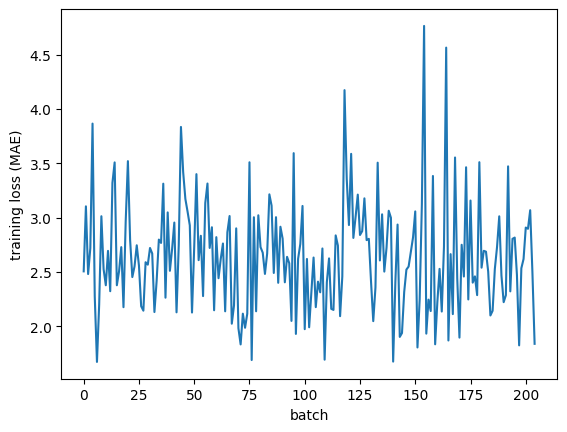

In [221]:
plt.plot(batch_losses);
plt.xlabel('batch');
plt.ylabel('training loss (MAE)');

Losset som beräknades under den allra sista iteration av träning är

In [222]:
batch_losses[-1]

1.8373711109161377

Detta betyder att *medelfelet* av våra prediktions, på hela vårt träningssätt är det värdet du ser ovan! Men betygen för varje person är ju också satt mellan 0-20, så ett medelfel på värdet du ser ovan är inte helt katastrofalt dåligt.

Det är ju dock ändå knappast optimalt - och anledningen är för att en Neuron är en ganska dålig modell :)

Här ville vi ju dock bara lära oss grunderna i PyTorch. Vi kommer lära oss betydligt bättre kraftfullare modeller snart.

## UPPGIFTER

**0)**

Vad hände ovan när vi tränade modellen? Varför ser MAE lossen ut som den gör? Does it make sense? Vad kan vi göra annorlunda?

<font color = "yellow">För varje iteration blir lossen mindre, vilket make sense. Anledningen att den är "taggig" beror antagligen på innehållet skiljer sig i varje batch. Det vi kan göra annorlunda är bland annat kanske ändra på batch storlek, ändra learning rate och ändra epok antalet.</font>


**1)** 

Låt oss direkt testa hur den tränade modellen presterar på vårt dataset. Välj själv en training sample, ange ett värde mellan 0-648.

Kan du hitta några training samples som modellen predictar särskilt bra/dåligt på? Jämför felen du får i dina svar med medelfelet vi fick ovan.

<p style="color:yellow">Den presterar sämre på viss såsom (6, 400, 200, 450) och bättre på (100, 465) det känns som att det är korrekt att medelvärdet av felen är det vi fått ovan </p>

In [223]:
model.eval();                                        # sätt modellen i evaluerings/predicion läge

training_sample = 100                                   # TESTA OLIKA VÄRDEN PÅ DENNA

y_true = training_set[training_sample, -1]           # extrahera sanna slutbetyget för givet training sample
input_features = training_set[training_sample, :-1]  # extrahera alla input features för samma training sample

y_prediction = model(input_features)                 # predicta slutbetyg, givet input features


print('True grade       :', y_true.item())
print('Predicted grade  :', y_prediction.item())

True grade       : 8.0
Predicted grade  : 13.2289457321167


**2)**

Åskådliggör modellens parametrar på nytt. 

Säkerställ att de har ändrats sedan vi initierade modellen.

In [214]:
weights, bias = model.parameters()

print('Weights:', weights)
print()
print('Bias:', bias.data)


Weights: Parameter containing:
tensor([[1.1907, 1.0155, 1.7865, 1.0438, 0.2593, 1.3423, 0.9072, 1.0199, 0.3038,
         1.8102, 0.4552, 0.8540, 0.9137, 1.3606, 1.0401, 0.5758, 0.4131, 0.2201]],
       requires_grad=True)

Bias: tensor([2.2858])


**3)**

Gå nu tillbaks till träningsloopen och testa att köra igenom den för ett par olika värden på epochs, och plotta på nytt. 

Testa värden på epochs med början på 1 och sluta på 50. Exempelvis 1, 5, 10, 15, ..., 45, 50.

Vad verkar hända?

**4)**

Återigen, gå tillbaks till träningsloopen. Sätt epochs = 100. Testa nu istället olika värden på learning rate

Testa följande värden på learning rate, i tur ordning

- 0.00001 
- 0.01
- 1

och plotta på nytt vår loss. Vad verkar hända? 

*Hint: jämför lossen* 

**5)**

Testa nu MAE prestanda från andra typer av modeller, sådana som vi lärde oss under förra kursen. Presterar vår Neuron bättre eller sämre?

Vad kan du dra för slutsats?